## Spooky Author Identification

The competition dataset contains text from works of fiction written by spooky authors of the public domain: Edgar Allan Poe, HP Lovecraft and Mary Shelley. The data was prepared by chunking larger texts into sentences using CoreNLP's MaxEnt sentence tokenizer, so you may notice the odd non-sentence here and there. Your objective is to accurately identify the author of the sentences in the test set.

#### Data fields
* id - a unique identifier for each sentence
* text - some text written by one of the authors
* author - the author of the sentence (EAP: Edgar Allan Poe, HPL: HP Lovecraft; MWS: Mary Wollstonecraft Shelley)

You can also find the dataset <a href = "https://www.kaggle.com/competitions/spooky-author-identification/overview"> here</a>

***

### Import necessary libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import Sequential,layers
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

### Read 'spooky.csv' dataset

In [4]:
df = pd.read_csv('spooky.csv')

In [5]:
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


### Drop 'id' column

In [6]:
df = df.drop(columns='id',axis=1)

In [7]:
df

,text,author
0,"This process, however, afforded me no means of...",EAP
1,It never once occurred to me that the fumbling...,HPL
2,"In his left hand was a gold snuff box, from wh...",EAP
3,How lovely is spring As we looked from Windsor...,MWS
4,"Finding nothing else, not even gold, the Super...",HPL
...,...,...
19574,"I could have fancied, while I looked at it, th...",EAP
19575,The lids clenched themselves together as if in...,EAP
19576,"Mais il faut agir that is to say, a Frenchman ...",EAP
19577,"For an item of news like this, it strikes us i...",EAP


In [8]:
df

,text,author
0,"This process, however, afforded me no means of...",EAP
1,It never once occurred to me that the fumbling...,HPL
2,"In his left hand was a gold snuff box, from wh...",EAP
3,How lovely is spring As we looked from Windsor...,MWS
4,"Finding nothing else, not even gold, the Super...",HPL
...,...,...
19574,"I could have fancied, while I looked at it, th...",EAP
19575,The lids clenched themselves together as if in...,EAP
19576,"Mais il faut agir that is to say, a Frenchman ...",EAP
19577,"For an item of news like this, it strikes us i...",EAP


### Check for missing values

In [9]:
df.isnull().sum()

text      0
author    0
dtype: int64

### Check for duplicates

In [10]:
df.duplicated().sum()

np.int64(0)

### Print some of the text along with its author

In [11]:
print(df['text'])

0        This process, however, afforded me no means of...
1        It never once occurred to me that the fumbling...
2        In his left hand was a gold snuff box, from wh...
3        How lovely is spring As we looked from Windsor...
4        Finding nothing else, not even gold, the Super...
                               ...                        
19574    I could have fancied, while I looked at it, th...
19575    The lids clenched themselves together as if in...
19576    Mais il faut agir that is to say, a Frenchman ...
19577    For an item of news like this, it strikes us i...
19578    He laid a gnarled claw on my shoulder, and it ...
Name: text, Length: 19579, dtype: object


### Create a function to preproces the text

In [12]:
def preprocessing(sentence):
    text = re.sub(r'[^A-Za-z0-9]',' ',sentence).split()
    words = [x.lower()for x in text if x not in stopwords.words('english')]
    lem = WordNetLemmatizer()
    word = [lem.lemmatize(word,'v') for word in words]
    return ' '.join(word)

In [13]:
df['text'] = df['text'].apply(preprocessing)

### Print some of the text after preprocess

In [14]:
for i in range(5):
    print(df['text'][i])
    print()

this process however afford mean ascertain dimension dungeon i might make circuit return point whence i set without aware fact perfectly uniform seem wall

it never occur fumble might mere mistake

in leave hand gold snuff box caper hill cut manner fantastic step take snuff incessantly air greatest possible self satisfaction

how lovely spring as look windsor terrace sixteen fertile counties spread beneath speckle happy cottages wealthier towns look former years heart cheer fair

find nothing else even gold superintendent abandon attempt perplex look occasionally steal countenance sit think desk



### Check for imbalance in the dataset

C:\Users\muham\AppData\Local\Temp\ipykernel_11432\3788115510.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['author'],palette='plasma')


<Axes: ylabel='count'>

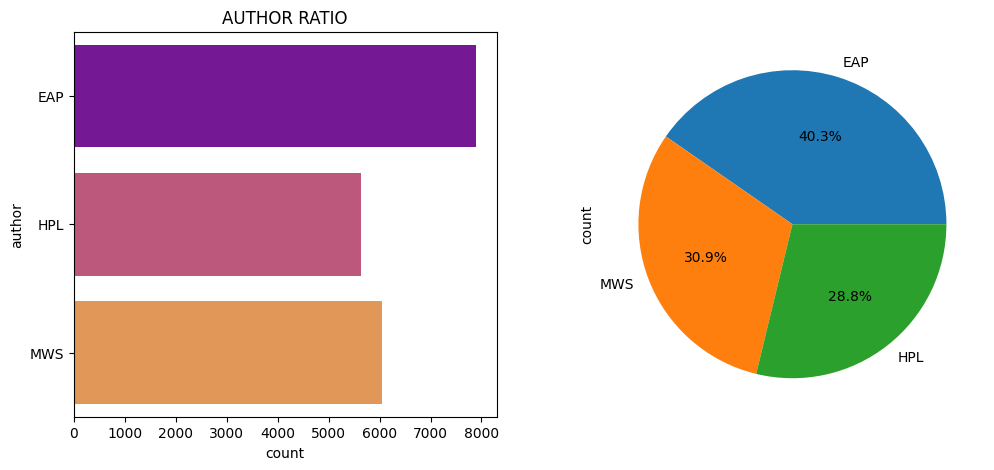

In [15]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('AUTHOR RATIO')
sns.countplot(y=df['author'],palette='plasma')
plt.subplot(1,2,2)
df['author'].value_counts().plot.pie(autopct= '%1.1f%%')

### Split the dataset into Input & Target Variables

In [16]:
x = df['text']
y = df['author']

In [17]:
y.unique()

array(['EAP', 'HPL', 'MWS'], dtype=object)

### Label Encode our target variables

In [18]:
y = y.map({'EAP':0,'HPL':1,'MWS':2})

### Create Keras tokenizer object with 5000 max words
* Convert text to sequence
* Add padding

In [19]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x)
vocab_size = len(tokenizer.word_index) + 1
def text_encoding(txt):
    encod = tokenizer.texts_to_sequences(txt)
    padded  =pad_sequences(encod,maxlen=128)
    return padded

### Split the dataset into Training & Testing set

In [20]:
xtrain, xtest,ytrain,ytest = train_test_split(x,y,test_size=0.3)
xtrain = text_encoding(xtrain)
xtest = text_encoding(xtest)

### Create keras Sequential model with GRU layers

In [21]:
model = Sequential()
model.add(layers.Embedding(vocab_size,128))
model.add(layers.GRU(128,return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.GRU(64))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64,activation='softmax'))

### Compile the model

In [22]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

### Train the model

In [23]:
model.fit(xtrain,ytrain,epochs = 10,validation_split = 0.02)

Epoch 1/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - accuracy: 0.3598 - loss: 1.5463 - val_accuracy: 0.4582 - val_loss: 1.0123
Epoch 2/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 44s 105ms/step - accuracy: 0.6075 - loss: 0.8512 - val_accuracy: 0.8255 - val_loss: 0.4636
Epoch 3/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 44s 106ms/step - accuracy: 0.8527 - loss: 0.3949 - val_accuracy: 0.8182 - val_loss: 0.4583
Epoch 4/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 44s 105ms/step - accuracy: 0.9095 - loss: 0.2554 - val_accuracy: 0.8182 - val_loss: 0.5180
Epoch 5/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 44s 105ms/step - accuracy: 0.9306 - loss: 0.1847 - val_accuracy: 0.8073 - val_loss: 0.6293
Epoch 6/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 45s 107ms/step - accuracy: 0.9484 - loss: 0.1347 - val_accuracy: 0.7927 - val_loss: 0.7406
Epoch 7/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 45s 106ms/step - accuracy: 0.9658 - loss: 0.0988 - val_accuracy: 0.7818 - val_loss: 0.9924
Epoch 8/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 45s 106ms/step - accuracy: 0.9740 - loss: 0

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 128, 128)       │     2,521,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128, 128)       │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,023,490 (30.61 MB)

 Trainable params: 2,674,496 (10.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,348,994 (20.40 MB)

### Make predictions with X_test

In [25]:
pred = model.predict(xtest)

184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step


In [26]:
pred = pred.argmax(axis=1)

### Fetch the index of the higher probable prediction

In [27]:
pred

array([1, 1, 1, ..., 0, 1, 2])

### Evaluate the model

In [28]:
model.evaluate(ytest,pred)

184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3879 - loss: 1.4515


[1.4520628452301025, 0.3854272961616516]

#### Accuracy score

In [29]:
accuracy_score(ytest,pred)

0.7778345250255363

#### Confusion matrix

<Axes: >

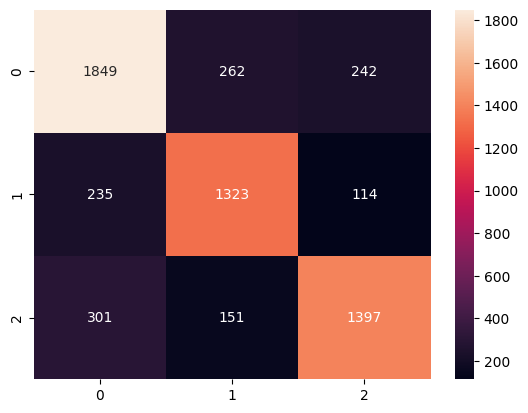

In [30]:
sns.heatmap(confusion_matrix(ytest,pred),annot=True,fmt='d')

#### Classification Report

In [31]:
print(classification_report(ytest,pred))

              precision    recall  f1-score   support

           0       0.78      0.79      0.78      2353
           1       0.76      0.79      0.78      1672
           2       0.80      0.76      0.78      1849

    accuracy                           0.78      5874
   macro avg       0.78      0.78      0.78      5874
weighted avg       0.78      0.78      0.78      5874



***